# Project - Mozilla Bug Report Analysis

## IMPORT NECESSARY LIBRARIES

In [1]:
import os, sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

ModuleNotFoundError: No module named 'tqdm'

## READ, ORGANIZE AND CLEAN DATA

In [2]:
"""
Sets paths and create a list of bugs for each directory
"""

path = ['./bugreports_v1_4' ,
        './bugreports_v1_7']

list_of_bugs = [os.listdir(directory) for directory in path]

In [3]:
"""
Cleans raw data and creates a list of dataframes for each version 
"""
columns = ['bugid', 'product', 'product version','platform', 'platform version','status', 'severity', 
           'resolution', 'component', 'target milestone', 'summary', 'keywords', 'status whiteboard','opened'] 

version_list = []
count = 0
for version in list_of_bugs:
    count += 1
    data_list = []
    for file in version:
        
        if count == 1:
            path = "./bugreports_v1_4\\" + file
        else: 
            path = "./bugreports_v1_7\\" + file
            
        days_file = open(path,'r')
        m= days_file.readlines()
        lean_data = [i.replace( '\n' , "") for i in [i.split(': ', 1)[1] for i in m[1:]]]
        data_list.append(lean_data)
        df=pd.DataFrame(data_list, columns = columns)
    version_list.append(df) 

## CHANGE TYPES and FILTER DATA

In [5]:
""" 1 Converts 'opened' column to datetime """
def convert_opened_column_to_date():
    """ 
    Takes a list of dataframes as an input
    Returns a list of modified columned dataframes 
    """
    for k in  range(len(version_list)):
        version_list[k]['opened'] = pd.to_datetime(version_list[k]['opened'])
    return version_list

In [6]:
""" 2
Filters 'severity' and 'resolution' columns by using boolean masking 
Sorts values by opened column 
"""

def filter_function():
    """ 
    Takes a list of dataframes as an input (The output of the convert_opened_column_to_date)
    Returns a list of filtered and sorted dataframes 
    """
    for k in  range(len(version_list)):
        version_list[k] = version_list[k][(~version_list[k]['severity'].isin(['enhancement','trivial', 'minor' ]))
                                      & (~version_list[k]['resolution'].isin(['DUPLICATE','INVALID']))].sort_values(by=['opened']).reset_index().drop('index', axis = 1)
    return version_list

## Starting from this point every dataframe will be evaluated individually

In [7]:
""" 3 Calculates the time difference between two bugs and inserts a new column for it """

def interarrival_times(dataframe):
    """ 
    Takes a dataframe as an input (A member of output of the filter_function)
    Returns a modified dataframe with a new column : interarrival_times(minutes)
    """
    df_int = dataframe.copy()
    df_int['interarrival_times'] = (df_int['opened'].diff()).apply(lambda x : x.total_seconds()/60)
    return df_int

In [8]:
""" Inserts two more columns to dataframe : 'date' and 'month' to create summary tables"""
def add_date_and_month_columns(dataframe):
    """ 
    Takes a dataframe as an input 
    Returns a modified dataframe with 2 new columns : date and month by using 'opened' column
    """
    df_date = dataframe.copy()
    df_date['opened_date'] = df_date['opened'].dt.date
    df_date['opened_month'] = pd.to_datetime(df_date['opened']).dt.to_period('M')
    return df_date

In [41]:
""" 4 Plots interarrival times according to date"""
def plot_interarrival_times(dataframe):
    """ 
    Takes a dataframe as an input 
    Returns a bar chart with x:opened_date and y:interarrival_times
    """
    dataframe.plot(kind='line',x='opened_date',y='interarrival_times')
    plt.xticks(rotation = 60)
    return plt.show()

In [63]:
""" 5 Calculates the number of bugs per day and per month and creates plots for them."""
def create_and_plot_summary_table(dataframe, visual_type = 'table', date_type = 'month'):
    """ 
    Takes; a dataframe 
           visual_type: 'table' or 'graph'
           date_type: 'month' or 'day'
    as inputs
    Returns a pivot table or a chart with x: 'opened_date' or 'opened_month' and y:interarrival_times
    """
    
    if date_type == 'month':
        monthly_frequency = dataframe[['opened_month', 'bugid']].groupby('opened_month').count().reset_index()
        if visual_type == 'table':
            return monthly_frequency
        elif visual_type == 'graph':
            return monthly_frequency.plot(kind='bar',x='opened_month',y='bugid',color='red')
        else: 
            return print('Your visual type inputs are not available in possible monthly options')
    elif date_type == 'day':
        daily_frequency = dataframe[['opened_date', 'bugid']].groupby('opened_date').count().reset_index()
        if visual_type == 'table':
            return daily_frequency
        elif visual_type == 'graph':
            return daily_frequency.plot(kind='bar',x='opened_date',y='bugid',color='red')
        else: 
            return print('Your visual type inputs are not available in possible daily options')
    else: 
        return print('Your date type inputs are not available in possible options')
    
#it is also possible to do the same thing with the code which is below, however above one is more sensitive to errors

#def create_and_plot_summary_table(dataframe, visual_type = 'table', date_type = 'month'):
#    monthly_frequency = dataframe[['opened_month', 'bugid']].groupby('opened_month').count().reset_index()
#    daily_frequency = dataframe[['opened_date', 'bugid']].groupby('opened_date').count().reset_index()
#    if (date_type == 'month') & (visual_type == 'table'):
#        return monthly_frequency
#    elif (date_type == 'month') & (visual_type == 'graph'):
#        return monthly_frequency.plot(kind='bar',x='opened_month',y='bugid',color='red')
#    elif (date_type == 'daily') & (visual_type == 'table'):
#        return daily_frequency
#    elif (date_type == 'daily') & (visual_type == 'graph'):
#        return daily_frequency.plot(kind='bar',x='opened_date',y='bugid',color='red')
#    else:
#        return print('Your inputs are not available in possible options')

In [64]:
""" 6 Creates pivot table by grouping interarrival times by selected columns"""
def summarize_interarrival_times(dataframe, column = 'opened_month'):
    """ 
    Takes; a dataframe 
           column: used for grouping data
    as inputs
    Returns a pivot table of avg interarrival_times
    """
    pivot = dataframe[[column, 'interarrival_times']].groupby(column).mean()
    return pivot

# Run

In [65]:
#1
convert_opened_column_to_date()
#2
filter_function()

[       bugid                    product product version   platform  \
 0     204708                       Core           Trunk         PC   
 1     204715                       Core           Trunk         PC   
 2     204716  Mozilla Application Suite           Trunk         PC   
 3     204719                       Core           Trunk        All   
 4     204720                       Core           Trunk        All   
 5     204721                       Core           Trunk         PC   
 6     204727                       Core           Trunk        All   
 7     204728                       Core           Trunk         PC   
 8     204729                       Core           Trunk         PC   
 9     204731                       Core           Trunk         PC   
 10    204740                       Core           Trunk         PC   
 11    204744                       Core           Trunk        All   
 12    204746  Mozilla Application Suite           Trunk        All   
 13   

In [66]:
df_14 = version_list[0] 
df_17 = version_list[1] 

##### VERSION 1.4

In [76]:
#3
df_14 = interarrival_times(df_14)

In [77]:
df_14_date = add_date_and_month_columns(df_14)

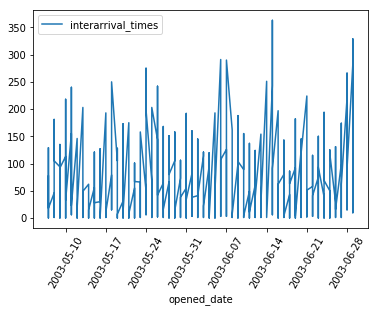

In [78]:
#4
plot_interarrival_times(df_14_date)

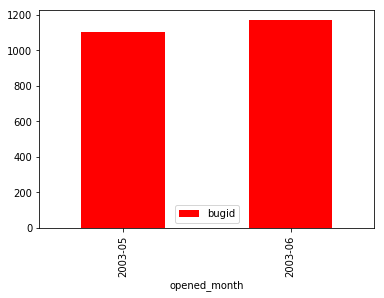

In [79]:
#5
create_and_plot_summary_table(df_14_date, visual_type = 'graph', date_type = 'month')

In [80]:
#6
summarize_interarrival_times(df_14_date, column = 'opened_month')

,interarrival_times
opened_month,
2003-05,32.522727
2003-06,35.754927


##### VERSION 1.7

In [81]:
#3
df_17 = interarrival_times(df_17)

In [82]:
df_17_date = add_date_and_month_columns(df_17)

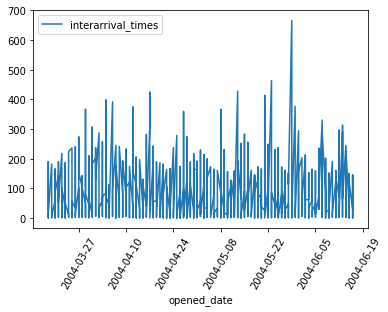

In [83]:
#4
plot_interarrival_times(df_17_date)

In [84]:
#5
create_and_plot_summary_table(df_17_date, visual_type = 'table', date_type = 'month')

,opened_month,bugid
0,2004-03,402
1,2004-04,888
2,2004-05,825
3,2004-06,457


In [85]:
#6
summarize_interarrival_times(df_17_date, column = 'opened_month')

,interarrival_times
opened_month,
2004-03,49.980050
2004-04,48.503378
2004-05,54.161212
2004-06,50.634573


### 7 Hypothesis Testing

In [86]:
"""
Hypotesis;

Ho is: “The population means are the same,
Ha is: “The population means are not the same, 
Alpha is to be set at 0.05. 

"""
#we exluded first row of the 2 samples with 'nan_policy' because of NaN values.
sample_14 = df_14['interarrival_times']
sample_17 = df_17['interarrival_times']

#We use ttest function from scipy library
#We need to perform a F test to be sure variances are equal and for that we need to perform a normality test 
#However, our p-value is so small, we are sure that these two samples are significantly different

t, p = stats.ttest_ind(sample_14, sample_17, equal_var = False, nan_policy = 'omit')

t, p ##(-11.599717949044855, 1.1048956242414644e-30)

#Our p value is 1.1048956242414644e-30 which is a quite small number so we reject the null hypotesis with 0.05 Alpha 
#and conclude: In 0.05 Alpha level, average of these two populations are not the same.

(-11.599717949044855, 1.1048956242414644e-30)